In [ ]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set()
from graphviz import Digraph


# Task 1 Load Data

## Task 1-1 Read annotations

In [ ]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

## Task 1-2 Load categories and super categories

In [ ]:
cat_names = []
categoriescat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


In [ ]:
pd.DataFrame([super_cat_names, 
              super_cat_ids, 
              cat_names], 
             index=['super_cat_names', 'super_cat_ids', 'cat_names'])

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
super_cat_names,Aluminium foil,Battery,Blister pack,Bottle,Bottle cap,Broken glass,Can,Carton,Cup,Food waste,...,None,None,None,None,None,None,None,None,None,None
super_cat_ids,Aluminium foil,Battery,Blister pack,Bottle,Bottle cap,Broken glass,Can,Carton,Cup,Food waste,...,None,None,None,None,None,None,None,None,None,None
cat_names,Aluminium foil,Battery,Aluminium blister pack,Carded blister pack,Other plastic bottle,Clear plastic bottle,Glass bottle,Plastic bottle cap,Metal bottle cap,Broken glass,...,Pop tab,Rope & strings,Scrap metal,Shoe,Squeezable tube,Plastic straw,Paper straw,Styrofoam piece,Unlabeled litter,Cigarette


## Task 1-3 EDA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  if __name__ == '__main__':


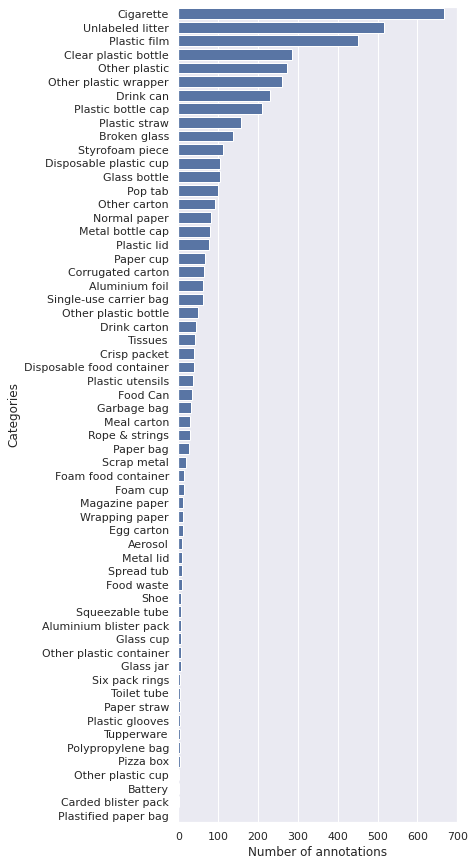

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only


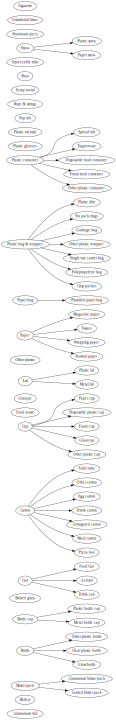

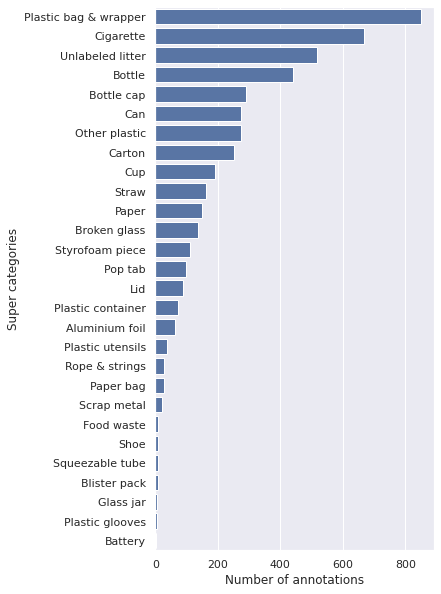

In [ ]:
def count_cats():
  cat_histogram = np.zeros(nr_cats,dtype=int)
  for ann in anns:
      cat_histogram[ann['category_id']] += 1

  f, ax = plt.subplots(figsize=(5,15))

  df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
  df = df.sort_values('Number of annotations', 0, False)

  plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
              label="Total", color="b")
  plt.show()

def count_super_cats():
  cat_ids_2_supercat_ids = {}
  for cat in categories:
      cat_ids_2_supercat_ids[cat['id']] = super_cat_ids[cat['supercategory']]

  super_cat_histogram = np.zeros(nr_super_cats,dtype=int)
  for ann in anns:
      cat_id = ann['category_id']
      super_cat_histogram[cat_ids_2_supercat_ids[cat_id]] +=1
      
  f, ax = plt.subplots(figsize=(5,10))

  d ={'Super categories': super_cat_names, 'Number of annotations': super_cat_histogram}
  df = pd.DataFrame(d)
  df = df.sort_values('Number of annotations', 0, False)

  plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
              label="Total", color="b")


def graph_plot():
  
  dot = Digraph('Dataset graph', filename='asd.gv')
  dot.attr(rankdir='LR', size='8,10')

  for cat_it in categories:
      dot.node(cat_it['name'])
      if cat_it['name']==cat_it['supercategory']:
          dot.node(cat_it['supercategory'])
      else:
          dot.edge(cat_it['supercategory'], cat_it['name'])
  
  return dot
  

count_cats()
count_super_cats()
graph_plot()

## Task 2 Building Model

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import json
import os

In [ ]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 74761, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 74761 (delta 144), reused 204 (delta 109), pack-reused 74512
Receiving objects: 100% (74761/74761), 580.43 MiB | 25.16 MiB/s, done.
Resolving deltas: 100% (53014/53014), done.
cp: cannot stat '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf': No such file or directory


In [ ]:
# install object_detection library
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

In [ ]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [ ]:
# reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=5)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

    # res = [category_index.get(value)['name'] for index,value in enumerate(classes[0]) if scores[0,index] > 0.5]

    # return res

In [ ]:
DATA_DIR = './data'
ANNOTATIONS_FILE = DATA_DIR + '/' + 'annotations.json'
NCLASSES = 60

In [ ]:
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)
categories = data['categories']

print('Building label map from examples...')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    item.name = category['name']

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

Building label map from examples...
Label map witten to labelmap.pbtxt


In [ ]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [ ]:
detection_graph = reconstruct("./input/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


## Task 3 Downloading Data

In [ ]:
!python3 download.py

Note. If for any reason the connection is broken. Just call me again and I will start where I left.
1% completed.
2% completed.
3% completed.
4% completed.
5% completed.
6% completed.
7% completed.
8% completed.
9% completed.
10% completed.
11% completed.
12% completed.
13% completed.
14% completed.
15% completed.
16% completed.
17% completed.
18% completed.
19% completed.
20% completed.
21% completed.
22% completed.
23% completed.
 23% 340/1500 [03:58<13:32,  1.43it/s]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 362, in _error_catcher
    yield
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 444, in read
    data = self._fp.read(amt)
  File "/usr/lib/python3.7/http/client.py", line 465, in read
    n = self.readinto(b)
  File "/usr/lib/python3.7/http/client.py", line 509, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.re

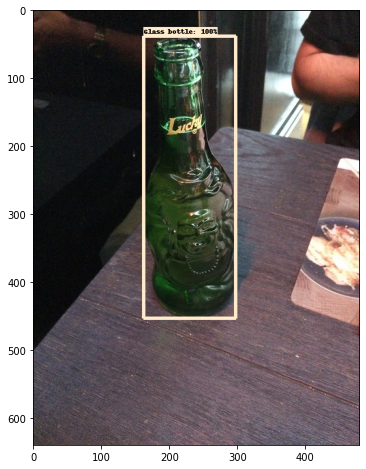

In [ ]:
detect(detection_graph, "./001.jpg")